In [3]:
from pandas_datareader import data as web
import pandas as pd
import datetime

# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,2)
end = datetime.date.today()
 
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
apple = web.DataReader("AAPL", "yahoo", start, end)
 
type(apple)

pandas.core.frame.DataFrame

In [4]:
apple.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,105.370003,102.000000,102.610001,105.349998,67649400.0,99.499107
2016-01-05,105.849998,102.410004,105.750000,102.709999,55791000.0,97.005730
2016-01-06,102.370003,99.870003,100.559998,100.699997,68457400.0,95.107361
2016-01-07,100.129997,96.430000,98.680000,96.449997,81094400.0,91.093399
2016-01-08,99.110001,96.760002,98.550003,96.959999,70798000.0,91.575073


Populating the interactive namespace from numpy and matplotlib


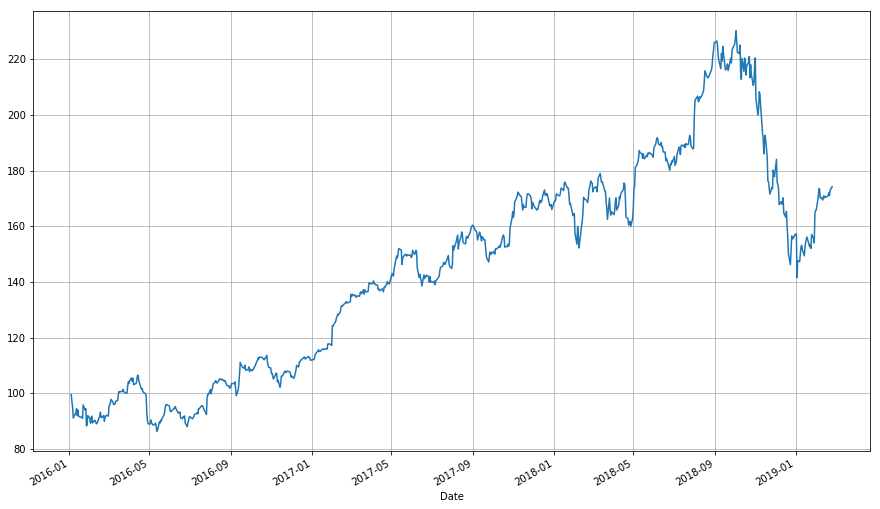

In [5]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
 
# Control the default size of figures in this Jupyter notebook
%pylab inline
 
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
apple["Adj Close"].plot(grid = True) # Plot the adjusted closing price of AAPL

In [10]:
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from mpl_finance import candlestick_ohlc

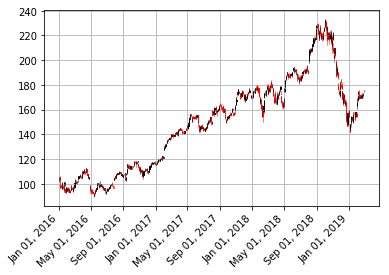

In [11]:

 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple)

In [12]:
microsoft = web.DataReader("MSFT", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})
 
stocks.head()

,AAPL,MSFT,GOOG
Date,,,
2016-01-04,99.499107,51.065639,741.840027
2016-01-05,97.005730,51.298611,742.580017
2016-01-06,95.107361,50.366753,743.619995
2016-01-07,91.093399,48.614864,726.390015
2016-01-08,91.575073,48.763962,714.469971


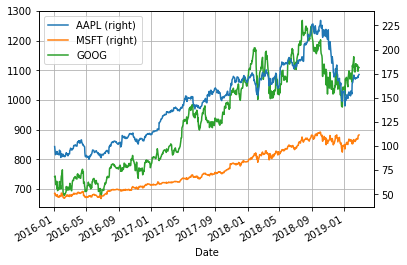

In [13]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

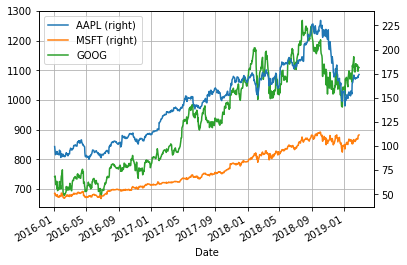

In [14]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)


In [15]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,AAPL,MSFT,GOOG
Date,,,
2016-01-04,1.000000,1.000000,1.000000
2016-01-05,0.974941,1.004562,1.000998
2016-01-06,0.955861,0.986314,1.002399
2016-01-07,0.915520,0.952007,0.979173
2016-01-08,0.920361,0.954927,0.963105


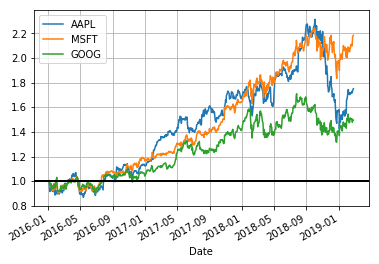

In [16]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

In [17]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,MSFT,GOOG
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,-0.025379,0.004552,0.000997
2016-01-06,-0.019764,-0.018332,0.001400
2016-01-07,-0.043121,-0.035402,-0.023443
2016-01-08,0.005274,0.003062,-0.016546


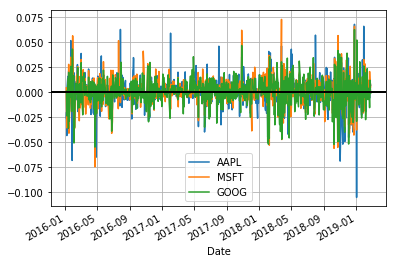

In [18]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

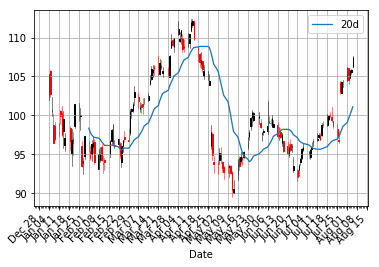

In [19]:
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

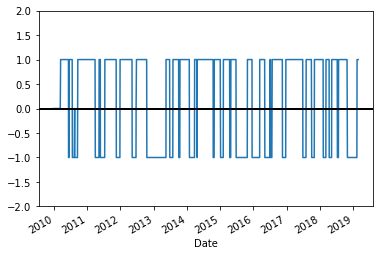

In [24]:
apple["Regime"].plot(ylim =(-2,2)).axhline(y =0, color ="black", lw =2)

In [25]:
apple["Regime"].value_counts()

 1    1443
-1     806
 0      53
Name: Regime, dtype: int64

In [35]:

# To ensure that all trades close out, I temporarily change the regime of the last row to 0
#regime_orig = apple.iloc[-1, "Regime"]
#apple.ix[-1, "Regime"] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
#apple.ix[-1, "Regime"] = regime_orig
apple.tail()

D:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sign
  """


,High,Low,Open,Close,Volume,Adj Close,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,
2019-02-19,171.440002,169.490005,169.710007,170.929993,18972800.0,170.929993,165.53,160.94,191.62,4.59,1.0,0.0
2019-02-20,173.320007,170.990005,171.190002,172.029999,26114400.0,172.029999,166.46,160.89,191.60,5.57,1.0,0.0
2019-02-21,172.369995,170.300003,171.800003,171.059998,17249700.0,171.059998,167.32,160.94,191.53,6.38,1.0,0.0
2019-02-22,173.000000,171.380005,171.580002,172.970001,18913200.0,172.970001,168.33,161.01,191.47,7.32,1.0,0.0
2019-02-25,175.869995,173.949997,174.160004,174.229996,21721100.0,174.229996,169.16,161.12,191.41,8.04,1.0,0.0


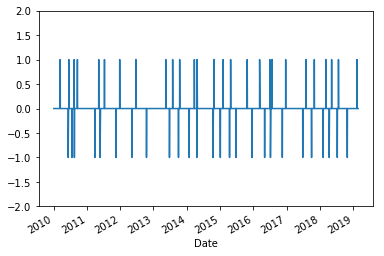

In [36]:
apple["Signal"].plot(ylim =(-2, 2))

In [37]:
apple["Signal"].value_counts()

 0.0    2246
 1.0      28
-1.0      27
Name: Signal, dtype: int64

In [38]:
apple.loc[apple["Signal"] ==1, "Close"]

Date
2010-03-15     31.977142
2010-06-18     39.152859
2010-08-16     35.377144
2010-09-20     40.461430
2011-05-12     49.509998
2011-07-14     51.110001
2011-12-28     57.520000
2012-06-22     83.157143
2012-06-25     81.538574
2013-05-17     61.894287
2013-07-31     64.647141
2013-10-16     71.587143
2014-03-26     77.111427
2014-04-25     81.705711
2014-10-28    106.739998
2015-02-05    119.940002
2015-04-28    130.559998
2015-10-27    114.550003
2016-03-11    102.260002
2016-07-01     95.889999
2016-07-25     97.339996
2016-12-22    116.290001
2017-08-02    157.139999
2017-11-01    166.889999
2018-03-08    176.940002
2018-05-10    190.039993
2018-07-24    193.000000
2019-02-12    170.889999
Name: Close, dtype: float64

In [39]:
apple.loc[apple["Signal"] ==-1, "Close"]

Date
2010-06-11     36.215714
2010-07-22     37.002857
2010-08-18     36.152859
2011-03-30     49.804287
2011-03-31     49.787144
2011-05-27     48.201427
2011-11-17     53.915714
2012-05-09     81.311432
2012-10-17     92.087143
2013-06-26     56.867142
2013-10-03     69.058571
2014-01-28     72.357140
2014-04-22     75.957146
2014-10-17     97.669998
2015-01-05    106.250000
2015-04-16    126.169998
2015-06-25    127.500000
2015-12-18    106.029999
2016-05-05     93.239998
2016-07-08     96.680000
2016-11-15    107.110001
2017-06-27    143.729996
2017-10-02    153.809998
2018-02-06    163.029999
2018-04-13    174.729996
2018-07-11    187.880005
2018-10-29    212.240005
Name: Close, dtype: float64

In [40]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2010-03-15,31.977142,1.0,Buy
2010-06-11,36.215714,-1.0,Sell
2010-06-18,39.152859,1.0,Buy
2010-07-22,37.002857,-1.0,Sell
2010-08-16,35.377144,0.0,Buy
2010-08-18,36.152859,-1.0,Sell
2010-09-20,40.461430,1.0,Buy
2011-03-30,49.804287,0.0,Sell
2011-03-31,49.787144,-1.0,Sell


In [41]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

ValueError: array length 25 does not match index length 26

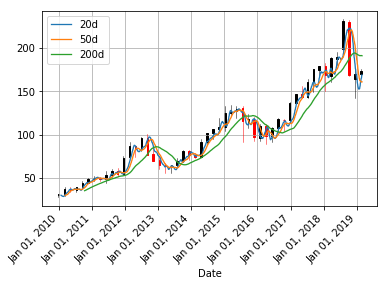

In [42]:
# Let's see the result over the whole period for which we have Apple data
pandas_candlestick_ohlc(apple, stick = 45, otherseries = ["20d", "50d", "200d"])

D:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
D:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
D:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sign
D:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


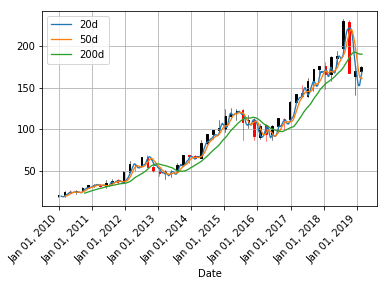

In [43]:
def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices
 
    :return: pandas DataFrame with adjusted stock data
 
    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas Yahoo! Finance API.
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                       "Close": dat["Adj Close"]})
 
apple_adj = ohlc_adj(apple)
 
# This next code repeats all the earlier analysis we did on the adjusted data
 
apple_adj["20d"] = np.round(apple_adj["Close"].rolling(window = 20, center = False).mean(), 2)
apple_adj["50d"] = np.round(apple_adj["Close"].rolling(window = 50, center = False).mean(), 2)
apple_adj["200d"] = np.round(apple_adj["Close"].rolling(window = 200, center = False).mean(), 2)
 
apple_adj['20d-50d'] = apple_adj['20d'] - apple_adj['50d']
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] < 0, -1, apple_adj["Regime"])
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple_adj.ix[-1, "Regime"]
apple_adj.ix[-1, "Regime"] = 0
apple_adj["Signal"] = np.sign(apple_adj["Regime"] - apple_adj["Regime"].shift(1))
# Restore original regime data
apple_adj.ix[-1, "Regime"] = regime_orig
 
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_adj_signals = pd.concat([
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == 1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == -1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_adj_signals.sort_index(inplace = True)
apple_adj_long_profits = pd.DataFrame({
        "Price": apple_adj_signals.loc[(apple_adj_signals["Signal"] == "Buy") &
                                  apple_adj_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_adj_signals["Price"] - apple_adj_signals["Price"].shift(1)).loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_adj_signals["Price"].loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].index
    })
 
pandas_candlestick_ohlc(apple_adj, stick = 45, otherseries = ["20d", "50d", "200d"])

In [44]:
apple_adj_long_profits

,Price,Profit,End Date
Date,,,
2010-03-15,21.322453,2.540524,2010-06-10
2010-06-18,26.107246,-1.433630,2010-07-22
2010-09-20,26.979805,6.229847,2011-03-30
2011-05-12,33.013409,-0.872551,2011-05-27
2011-07-14,34.080307,1.870861,2011-11-17
2011-12-28,38.354515,15.864182,2012-05-09
2012-06-25,54.370174,8.928070,2012-10-17
2013-05-15,47.521889,-3.581448,2013-06-28
2013-07-31,50.145920,6.503952,2013-10-07


In [46]:
# We need to get the low of the price during each trade.
tradeperiods =pd.DataFrame({"Start": apple_adj_long_profits.index,
                            "End": apple_adj_long_profits["End Date"]})
apple_adj_long_profits["Low"] = tradeperiods.apply(lambdax: min(apple_adj.loc[x["Start"]:x["End"], "Low"]), axis =1)
apple_adj_long_profits

TypeError: ('<lambda>() takes 0 positional arguments but 1 was given', 'occurred at index 2010-03-15 00:00:00')

In [47]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash =1000000
apple_backtest =pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value =.1# Max proportion of portfolio bet on any trade
batch =100# Number of shares bought per batch
stoploss =.2# % of trade loss that would trigger a stoploss
forindex, row inapple_adj_long_profits.iterrows():
    batches =np.floor(cash *port_value) //np.ceil(batch *row["Price"]) # Maximum number of batches of stocks invested in
    trade_val =batches *batch *row["Price"] # How much money is put on the line with each trade
    ifrow["Low"] < (1-stoploss) *row["Price"]:   # Account for the stop-loss
        share_profit =np.round((1-stoploss) *row["Price"], 2)
        stop_trig =True
    else:
        share_profit =row["Profit"]
        stop_trig =False
    profit =share_profit *batches *batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest =apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash +profit,
                "End Date": row["End Date"],
                "Shares": batch *batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index =[index]))
    cash =max(0, cash +profit)
 
apple_backtest

SyntaxError: invalid syntax (<ipython-input-47-c1e9d35eef8b>, line 15)

In [48]:
spyder =web.DataReader("SPY", "yahoo", start, end)
spyder.iloc[[0,-1],:]


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,112.800003,111.389999,112.769997,111.440002,90637900.0,92.968788
2019-02-26,280.290009,278.899994,279.130005,279.339996,56844101.0,279.339996


In [51]:
batches =1000000//np.ceil(100*spyder.loc[0,"Adj Close"]) # Maximum number of batches of stocks invested in
trade_val =batches *batch *spyder.loc[0,"Adj Close"] # How much money is used to buy SPY
final_val =batches *batch *spyder.loc[-1,"Adj Close"] +(1000000-trade_val) # Final value of the portfolio
final_val

TypeError: cannot do index indexing on <class 'pandas.core.indexes.datetimes.DatetimeIndex'> with these indexers [0] of <class 'int'>